In [1]:
import matplotlib.pyplot as plt
import os
import json
from tqdm import tqdm
import pandas as pd
import pickle
print("success")

success


In [3]:
if os.getcwd()[-9:] == "notebooks":
    os.chdir(os.path.dirname(os.getcwd()))
os.getcwd()

'/home/koos/Documents/timeseries_transfer_learning'

In [6]:
from utils.OurNBeatsModel import OurNBeatsModel
from utils.OurDataset import OurDataset
from utils.utils import list_of_timeseries_to_tensor, reverse_normalization
from utils.metric import *

In [ ]:
# Get loss for our own models
with open("results/losses.json", "r") as file:
    losses = json.load(file)

In [ ]:
key_mapping = {'best_stock': 'Only Stock', 'best_enrich_10': 'Enrich 10%', 'best_enrich_40': 'Enrich 40%', "best_enrich_10_without_darts": "Enrich 10% without darts", "best_enrich_40_without_darts": "Enrich 40% without darts"}

losses = {key_mapping.get(old_key, old_key): value for old_key, value in losses.items()}
models = list(losses.keys())
models

In [6]:
def normalize_whole_list(lst):
    lst = np.array(lst)
    min_value = min(lst)
    max_value = max(lst)
    if min_value == max_value:
        return lst, (min_value, max_value)
    else:
        return (((lst - min_value) / (max_value - min_value))), (min_value, max_value)

In [7]:
loss_functions = all_metrices[:-1]
loss_functions

[L1Loss(),
 MedianAbsoluteError(),
 MSELoss(),
 MedianSquaredError(),
 HuberLoss(),
 MeanLastValueError(),
 MedianLastValueError(),
 MeanTotalReturnError(),
 MedianTotalReturnError(),
 GeometricMeanDailyReturnError(),
 MeanFinalReturnError(),
 MedianFinalReturnError()]

# Violin charts with individual loss

## Get TimeGPT loss

In [9]:
with open(f"results/timegpt/timegpt_results_504.json", "rb") as file:
    timegpt_results = json.load(file)
len(timegpt_results)

7574

In [9]:
normal_factors = []
last_features = []
losses["TimeGPT"] = [[] for _ in loss_functions]
for ticker_key in tqdm(timegpt_results):
    
    features = timegpt_results[ticker_key]["features"]
    _features, factors = normalize_whole_list(features)
    mi, ma = factors

    targets = timegpt_results[ticker_key]["targets"]
    _targets = torch.Tensor(np.array([[(x - mi) / (ma - mi) for x in targets]]))

    pred = timegpt_results[ticker_key]["output"]["data"]["value"]
    _pred = torch.Tensor(np.array([[(x - mi) / (ma - mi) for x in pred]]))

    for i, loss_fn in enumerate(loss_functions):
        if hasattr(loss_fn, "pass_features_and_normal_factors"):
                loss = loss_fn(_pred, _targets, [darts.TimeSeries.from_series(_features)], [factors])
        else:
            loss = loss_fn(_pred, _targets)
        losses["TimeGPT"][i].append(float(loss))
    

100%|██████████| 7574/7574 [01:11<00:00, 105.57it/s]


## Get Arima Loss

In [10]:
with open(f"results/arima/arima_results_504", "rb") as file:
    all_preds, all_targets, all_features, all_factors = pickle.load(file)
len(all_preds)

7624

In [11]:
normal_factors = []
last_features = []
losses["Arima"] = [[] for _ in loss_functions]
for i in tqdm(range(len(all_preds))):
    
    _features = all_features[i]


    _targets = torch.Tensor(np.array([all_targets[i].values().flatten()]))

    _pred = torch.Tensor(np.array([all_preds[i].values().flatten()]))


    for j, loss_fn in enumerate(loss_functions):
        if hasattr(loss_fn, "pass_features_and_normal_factors"):
            loss = loss_fn(_pred, _targets, [_features], [factors])
        else:
            loss = loss_fn(_pred, _targets)
        losses["Arima"][j].append(float(loss))
    

100%|██████████| 7624/7624 [00:35<00:00, 213.72it/s]


## Plot all

In [12]:
def drop_outliers(data, remove_percent):
    if remove_percent == 0:
        return data

    num_to_remove = int(len(data) * remove_percent)


    sorted_data = np.sort(data)
    filtered_data = sorted_data[:-num_to_remove]

    return filtered_data


Metric: L1Loss()


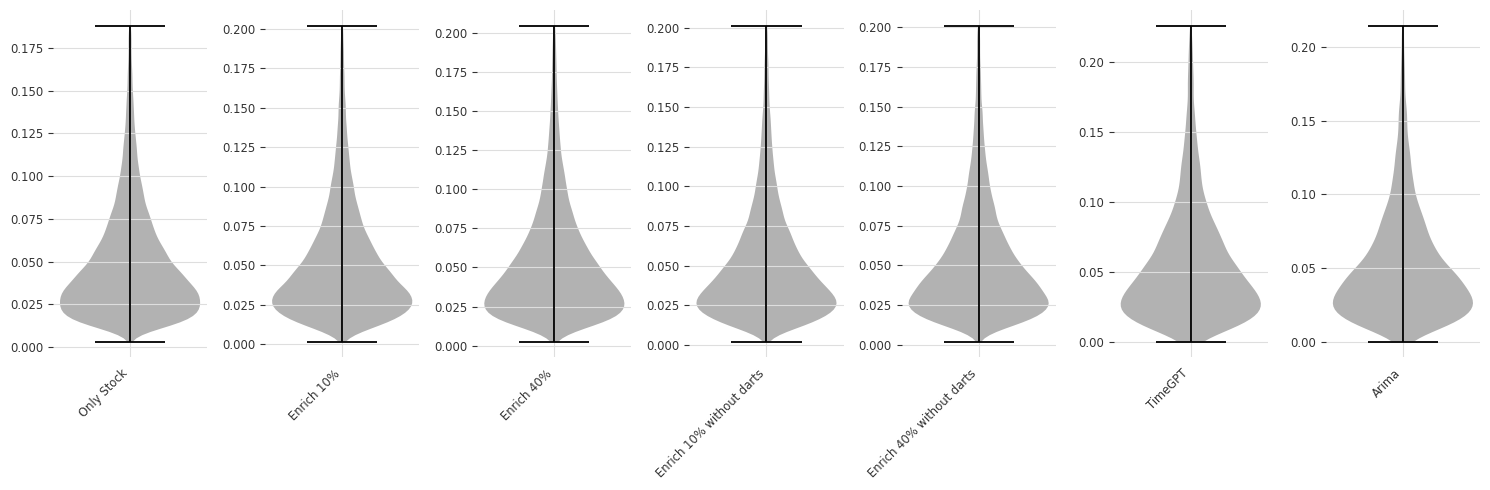

Metric: MedianAbsoluteError()


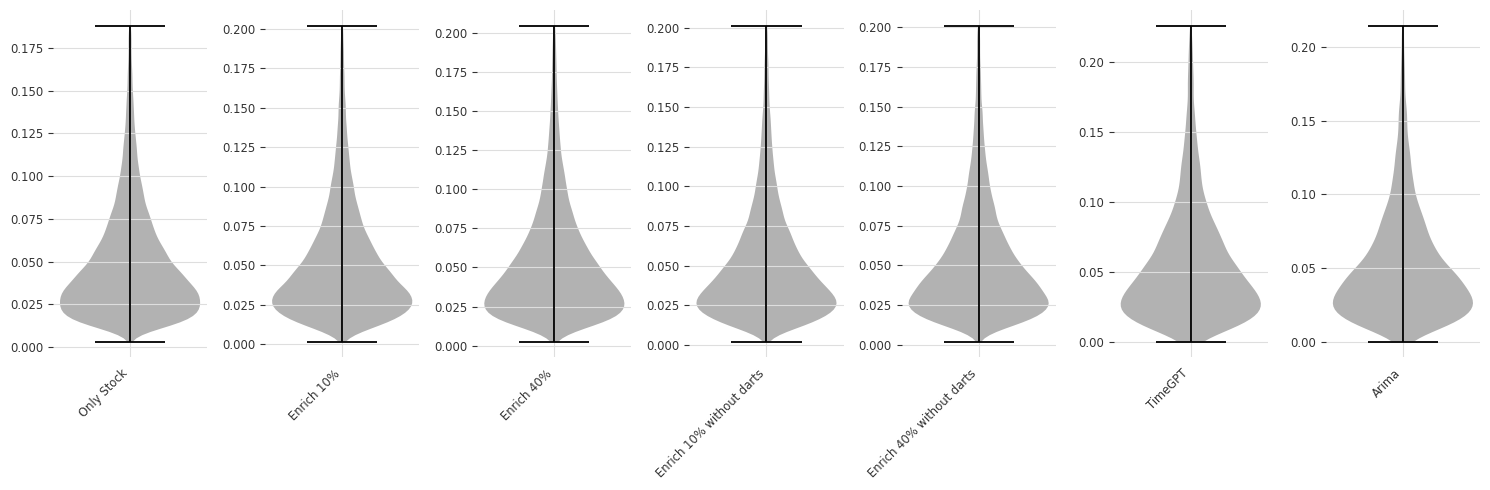

Metric: MSELoss()


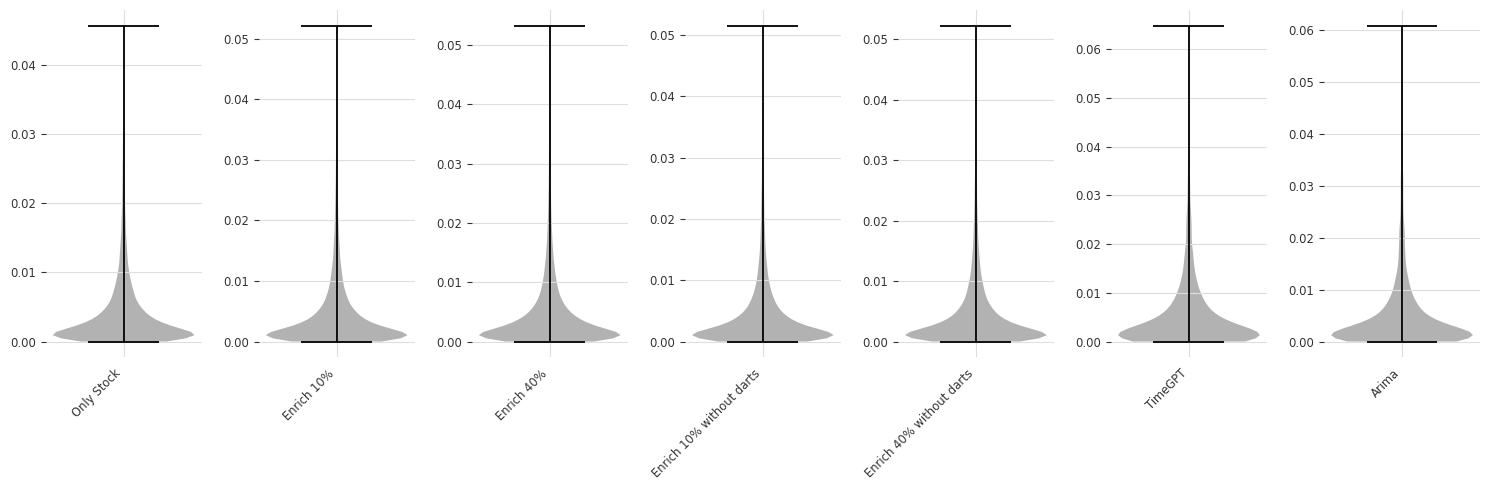

Metric: MedianSquaredError()


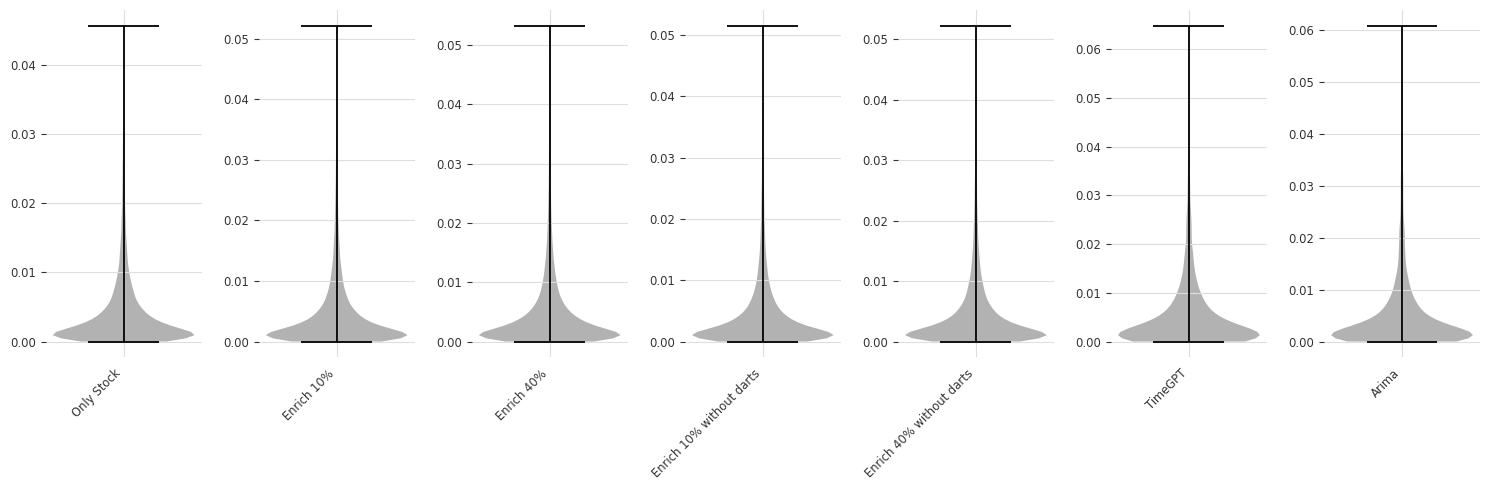

Metric: HuberLoss()


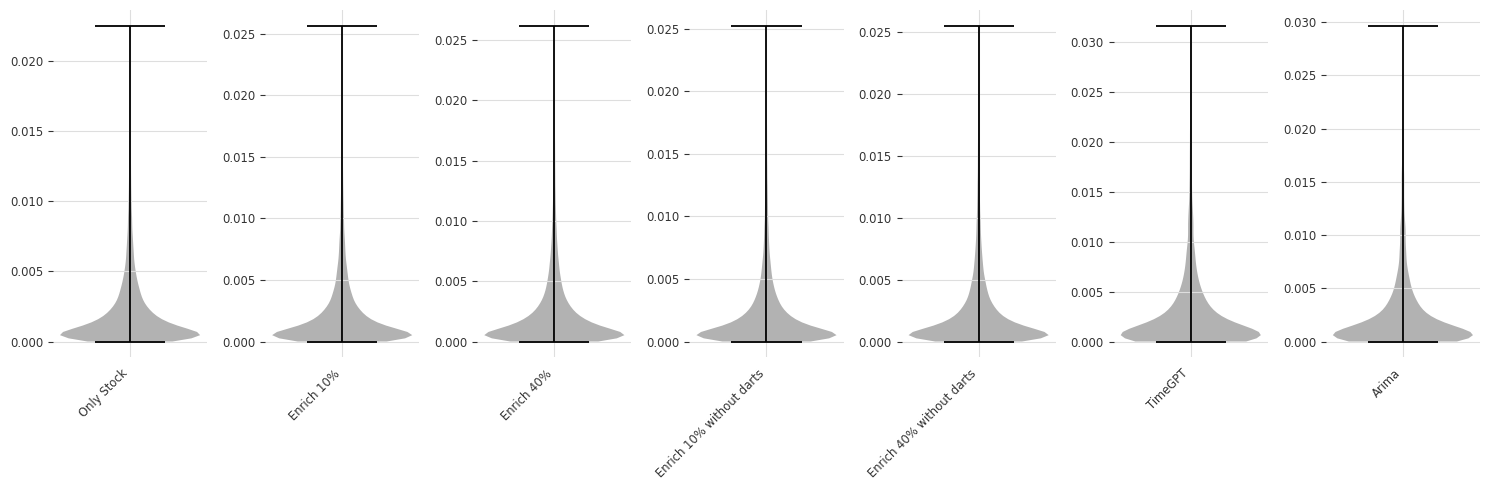

Metric: MeanLastValueError()


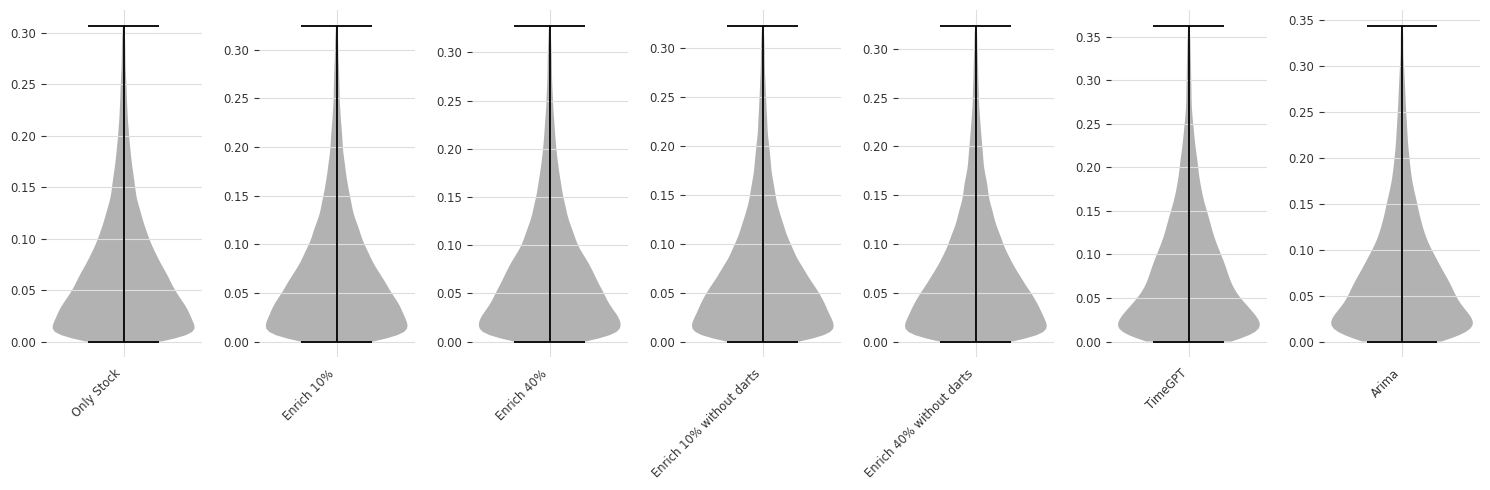

Metric: MedianLastValueError()


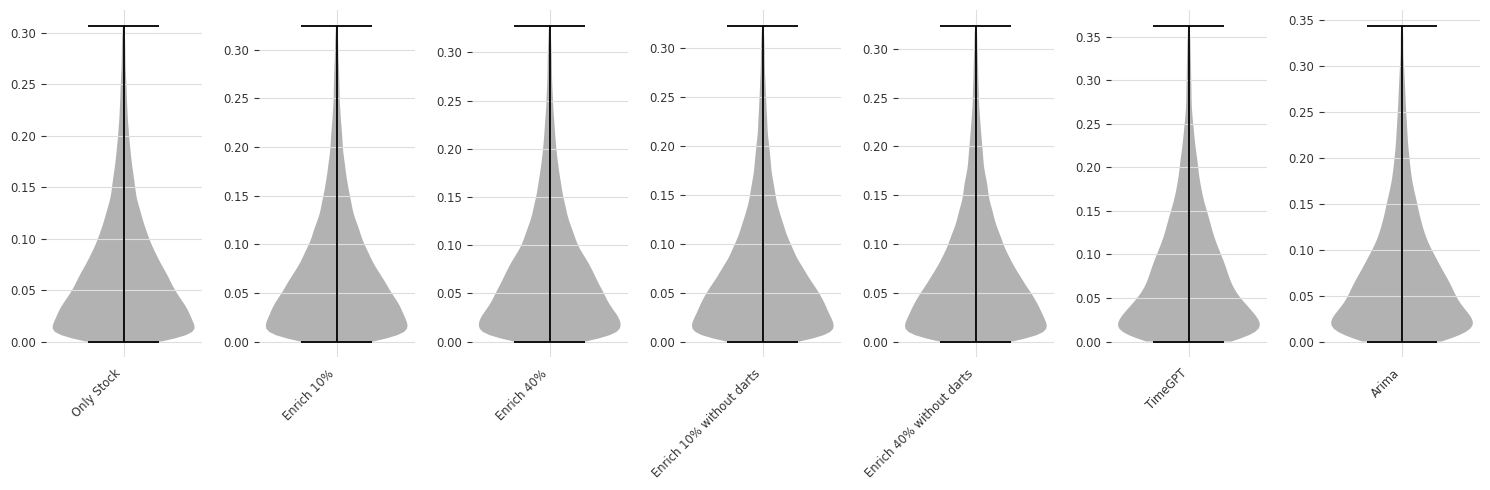

Metric: MeanTotalReturnError()


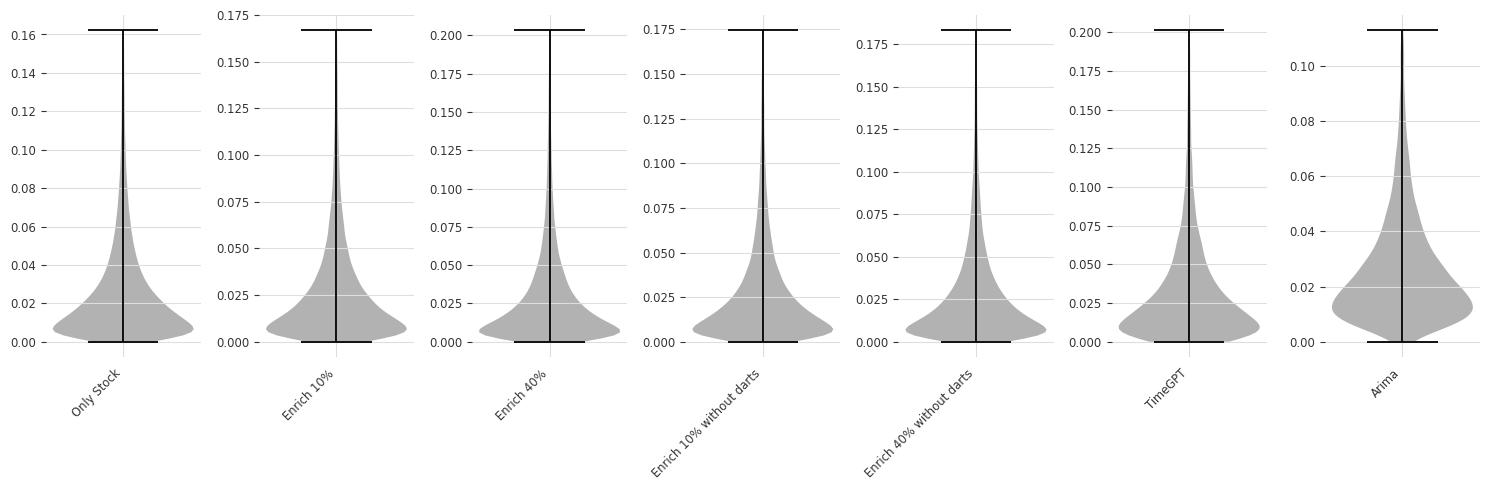

Metric: MedianTotalReturnError()


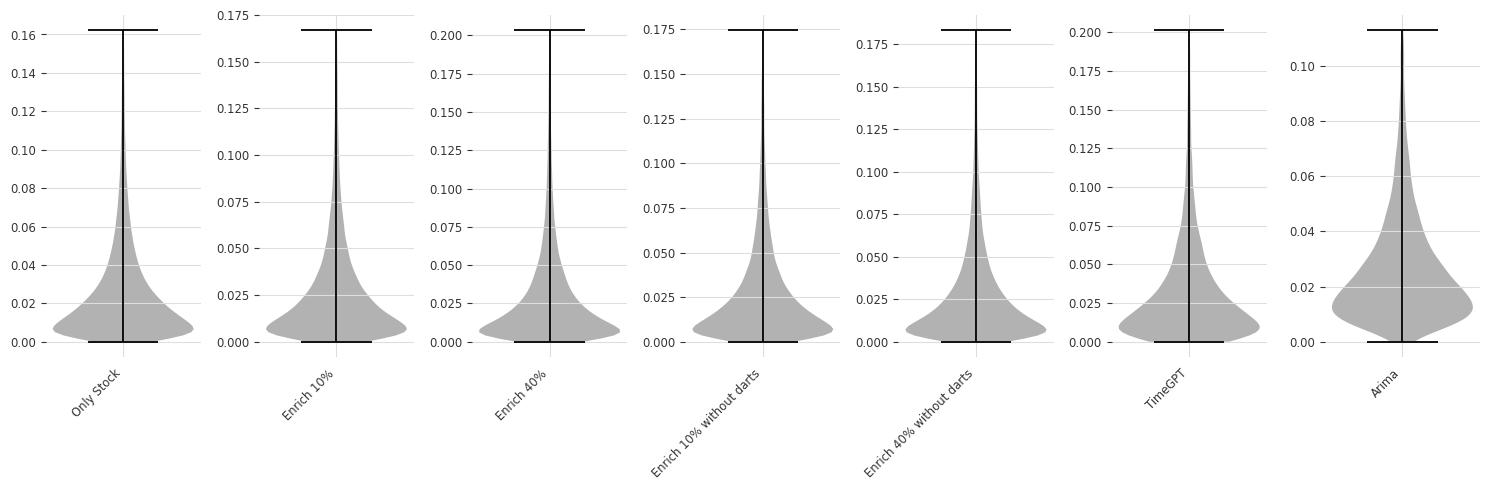

Metric: GeometricMeanDailyReturnError()


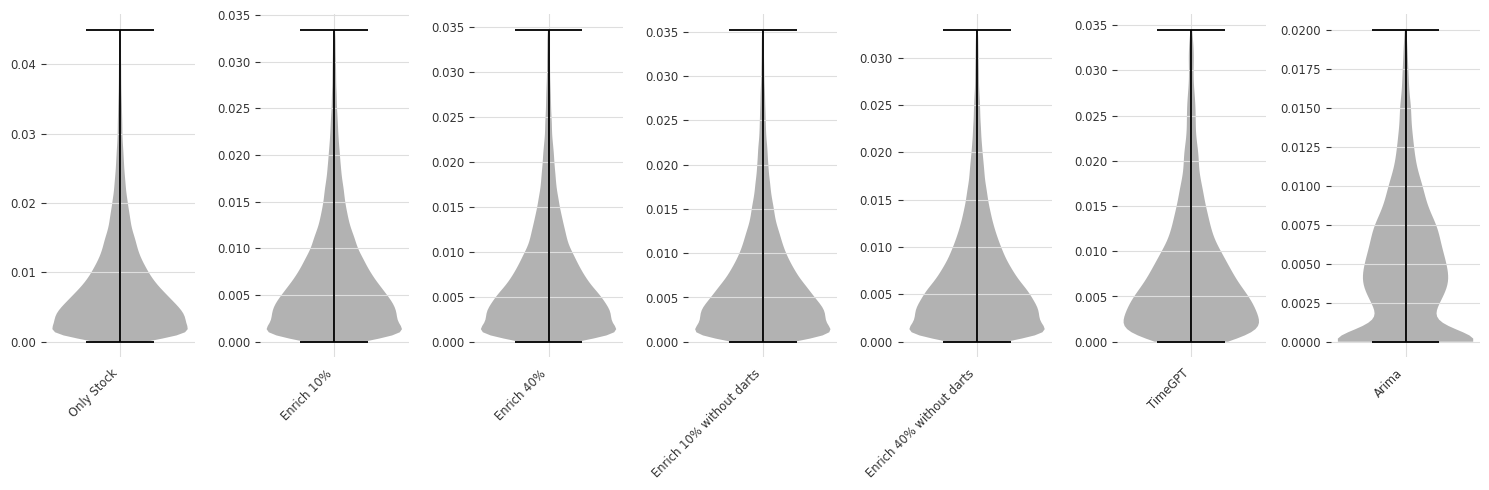

Metric: MeanFinalReturnError()


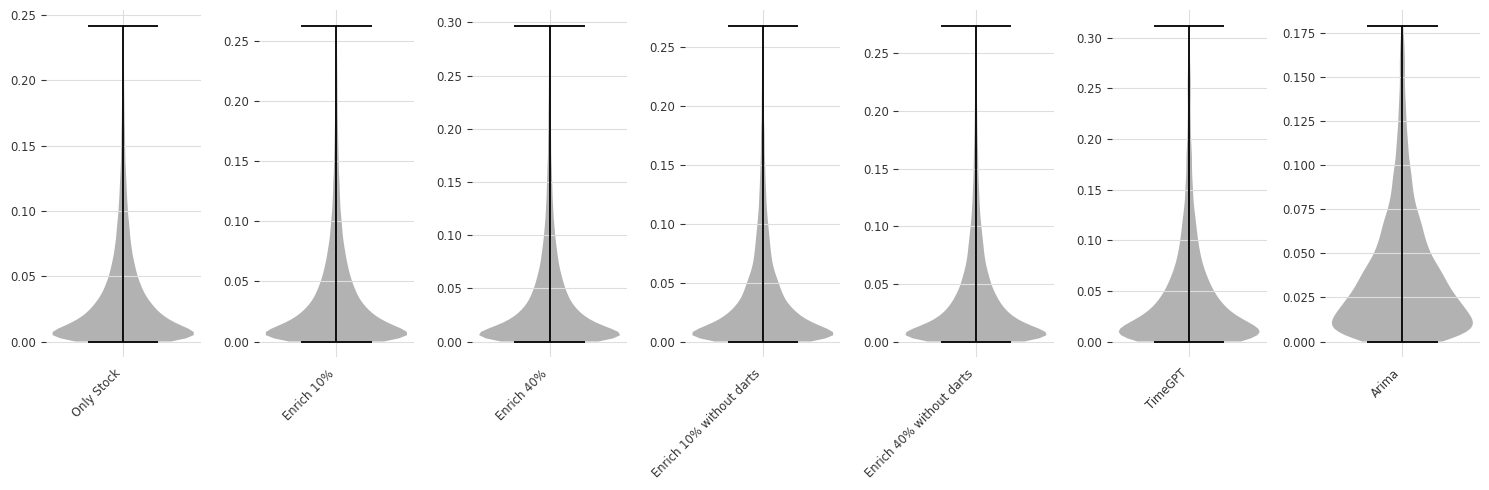

Metric: MedianFinalReturnError()


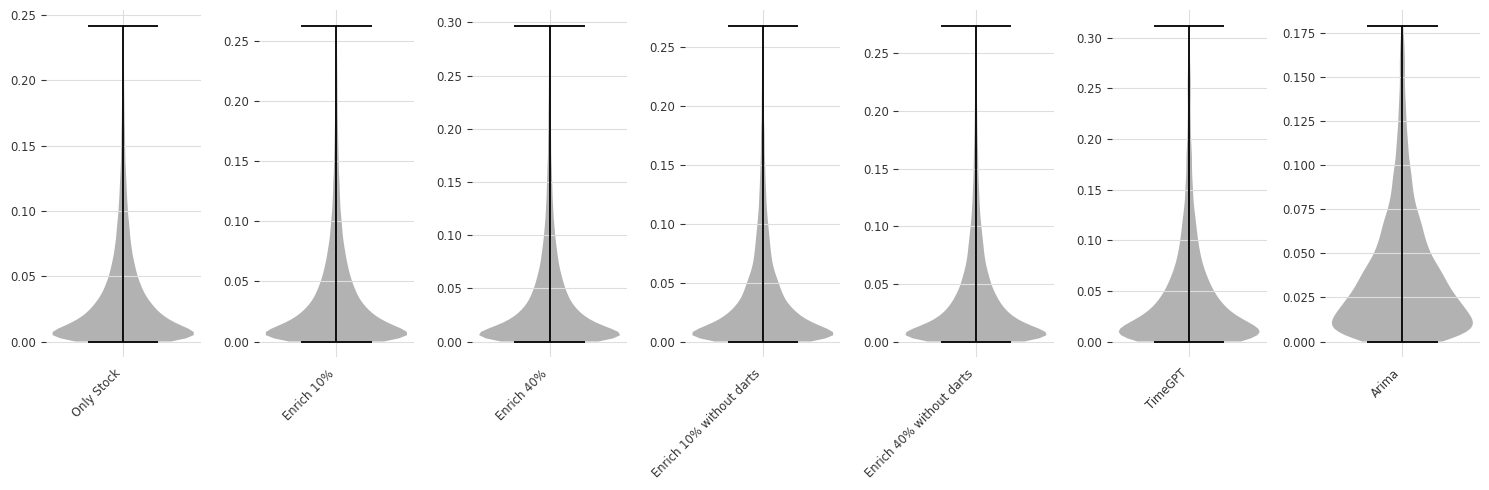

In [13]:
# Compare Models
labels = [
    "Mean Absolute Error",
    "Median of Mean Absolute Error",
    "Mean Squared Error",
    "Median of Mean Squared Error",
    "Huber Loss",
    "Mean Last Value Error",
    "Median of Last Value Error",
    "Mean Total Return Error",
    "Median of Mean Total Return Error",
    "Geometric Mean Daily Return Error",
    "Mean Final Return Error",
    "Median of Final Return Error"

]

for i, loss_fn in enumerate(loss_functions):
    print("Metric:", loss_fn)
    fig, axes = plt.subplots(1, len(losses), figsize=(15, 5))  # Adjust figsize as needed

    
    for j, model in enumerate(losses):
        ax = axes[j]
        parts = ax.violinplot(drop_outliers(losses[model][i], 0.02))
        #ax.set_title(str(loss_fn))

        # Adjust x-axis label rotation or position
        ax.set_xticks([1])
        ax.set_xticklabels([model], rotation=45, ha='right')  # Rotate labels

    plt.tight_layout()
    plt.savefig(f"violinplot_metric_{loss_fn}.png")
    plt.show()


Model: Only Stock


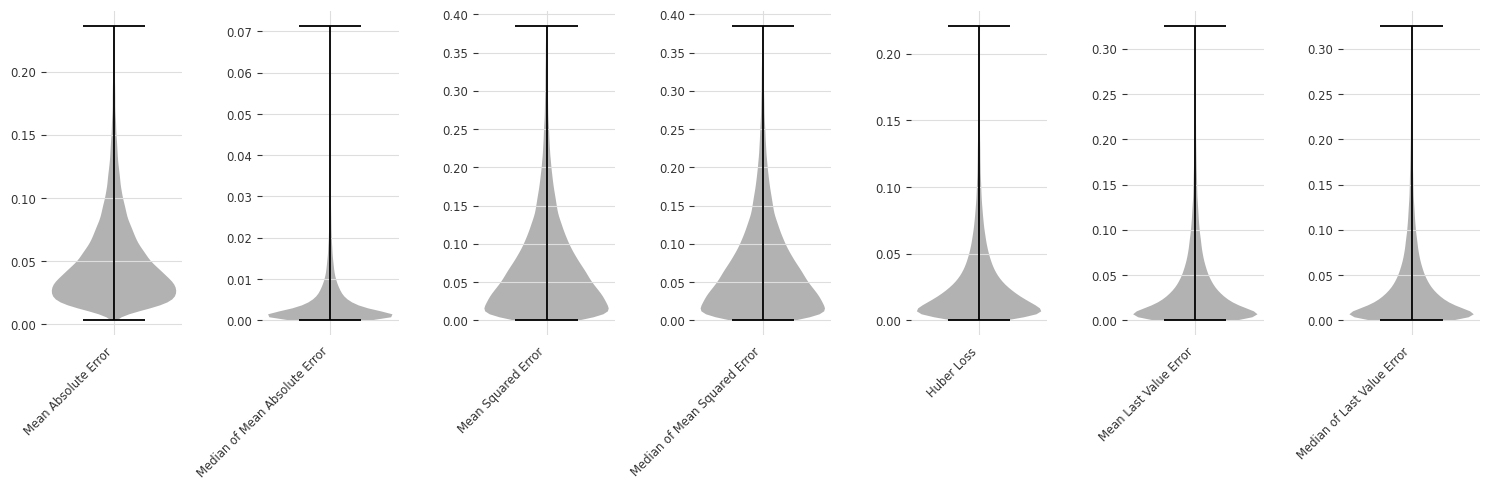

Model: Enrich 10%


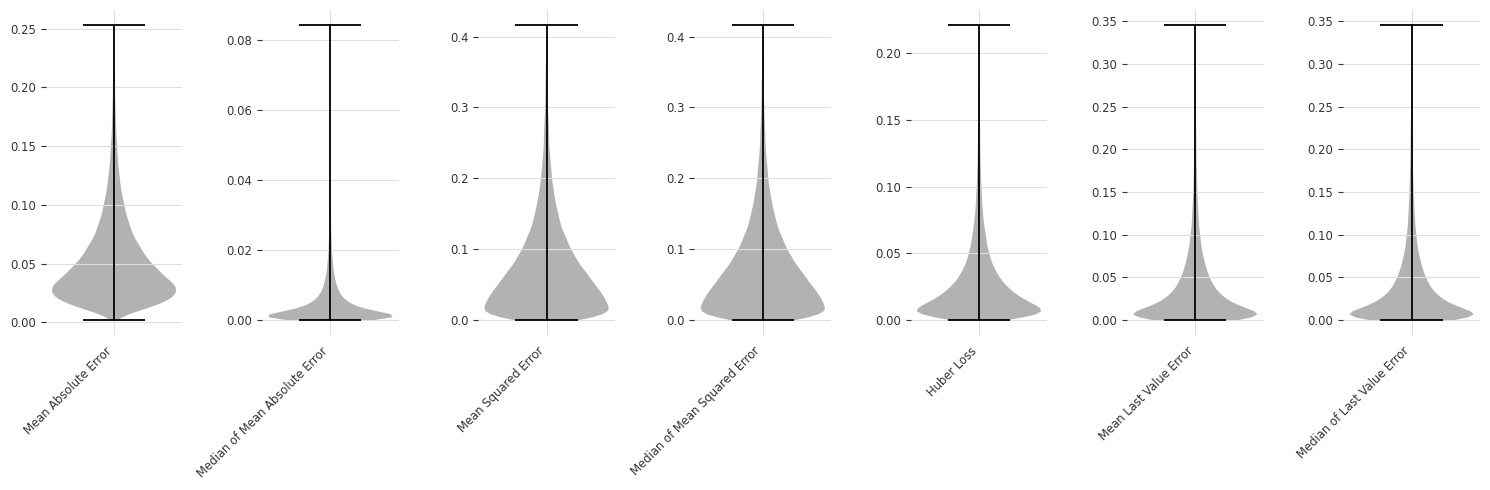

Model: Enrich 40%


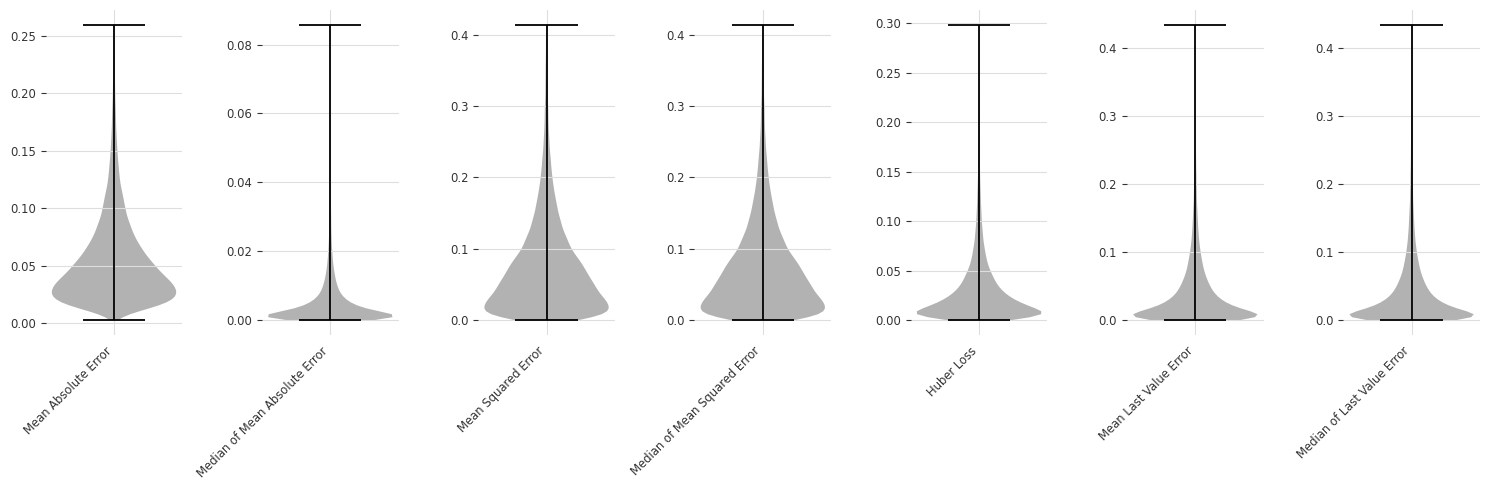

Model: Enrich 10% without darts


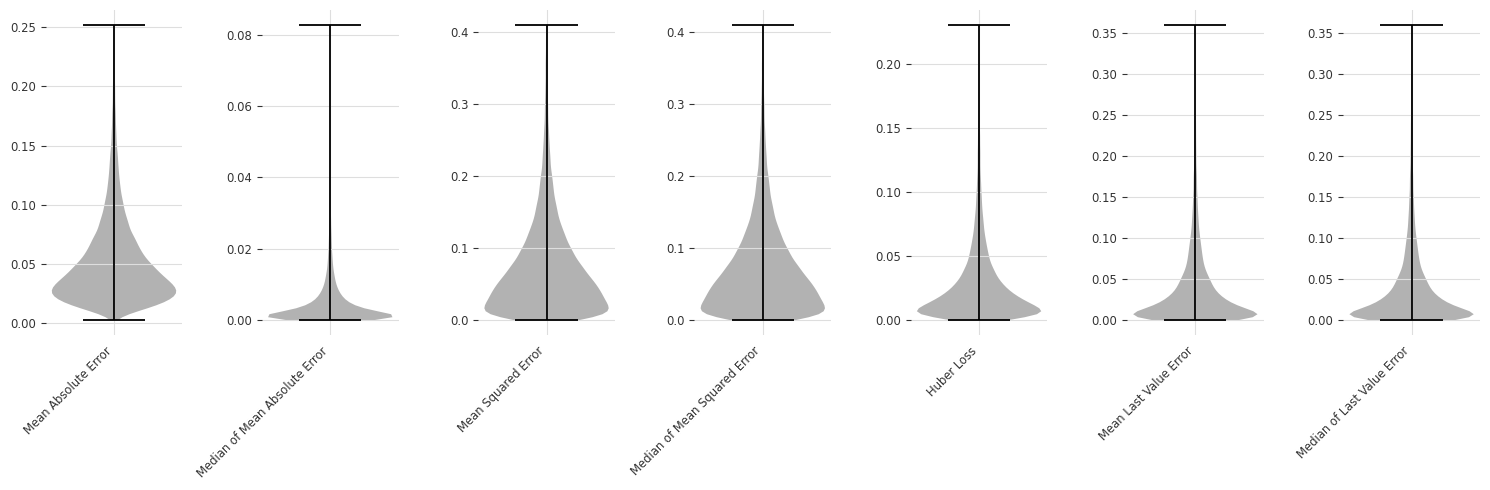

Model: Enrich 40% without darts


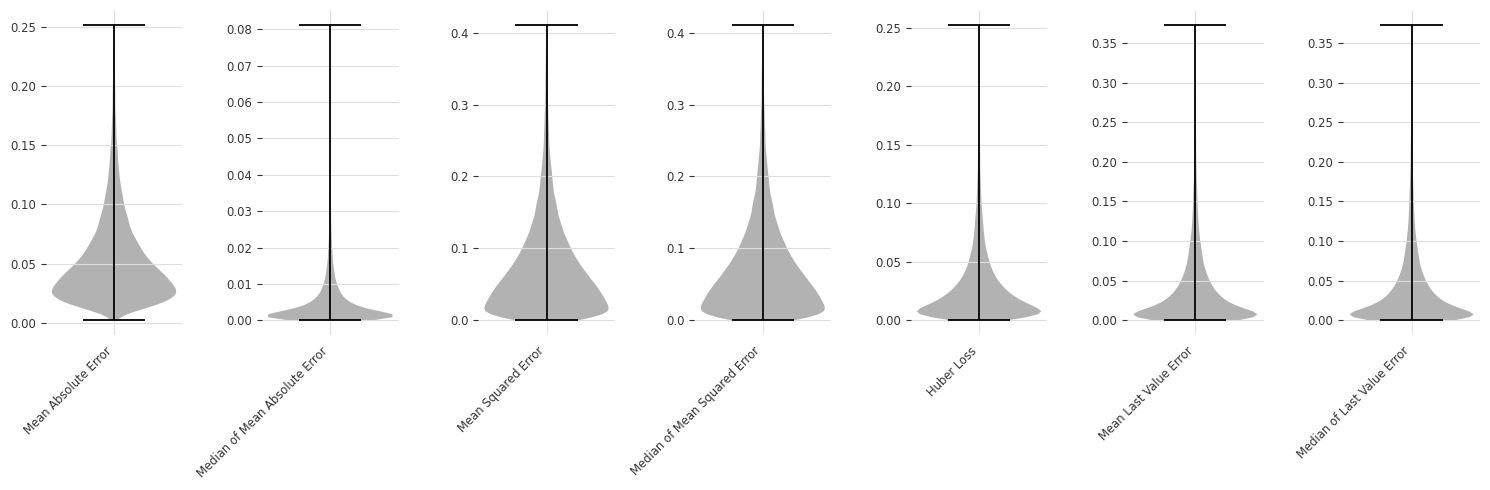

In [14]:
# Detail for single model

for model in models:
    fig, axes = plt.subplots(1, 7, figsize=(15, 5))  # Adjust figsize as needed

    for i, fn_index in enumerate([0, 3, 5, 6, 8, 10, 11]):
        loss_fn = loss_functions[fn_index]
        ax = axes[i]
        parts = ax.violinplot(drop_outliers(losses[model][fn_index], 0.01))
        #ax.set_title(str(loss_fn))

        # Adjust x-axis label rotation or position
        ax.set_xticks([1])
        ax.set_xticklabels([labels[i]], rotation=45, ha='right')  # Rotate labels
    plt.tight_layout()
    plt.savefig(f"violinplot_model_{model}.png")
    print("Model:", model)
    plt.show()


# Loss Bar Chart

In [23]:
df = pd.read_excel("/home/koos/Documents/Bachelor Thesis/final training.ods")

df.transpose()
df.set_index("Loss Function", inplace=True)
df

,Only Stock,Enrich 10%,Enrich 40%,Enrich 10% without darts,Enrich 40% without darts,Arima,TimeGPT
Loss Function,,,,,,,
Mean Absolute Error,0.054915,0.056913,0.058653,0.056335,0.057229,0.057826,0.061544
Median of Mean Absolute Error,0.041404,0.042325,0.043986,0.041801,0.042720,0.042112,0.045115
Mean Squared Error,0.007028,0.007726,0.008019,0.007557,0.007717,0.011656,0.010172
Median of Mean Squared Error,0.002418,0.002465,0.002629,0.002418,0.002505,0.002499,0.002820
Huber Loss,0.003324,0.003598,0.003737,0.003532,0.003599,0.004032,0.004436
Mean Last Value Error,0.076454,0.080273,0.081376,0.079467,0.080063,0.084306,0.088692
Median Last Value Error,0.053268,0.056051,0.057426,0.055509,0.055770,0.058216,0.060788
Mean Total Return Error,0.032943,0.033677,0.040518,0.034996,0.037047,0.037076,0.045122
Median of Mean Total Return Error,0.017996,0.018226,0.018754,0.017985,0.018362,0.020328,0.021826


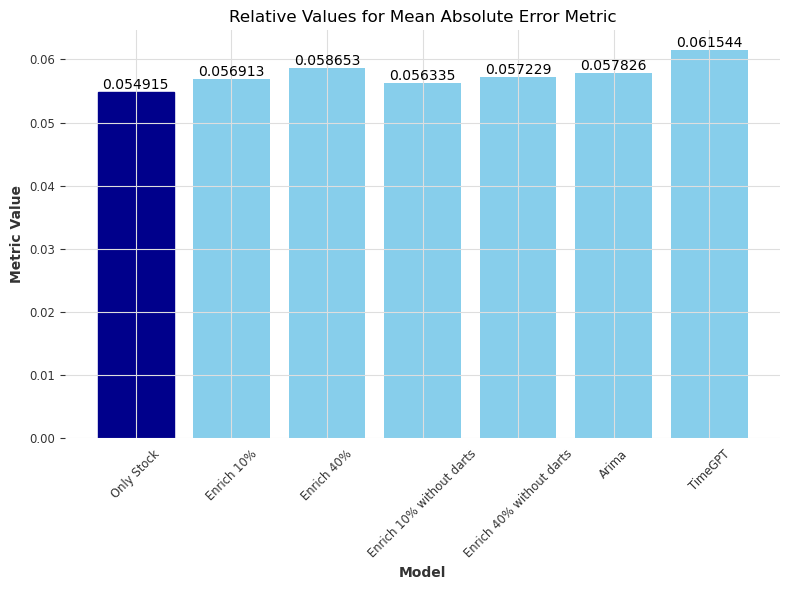

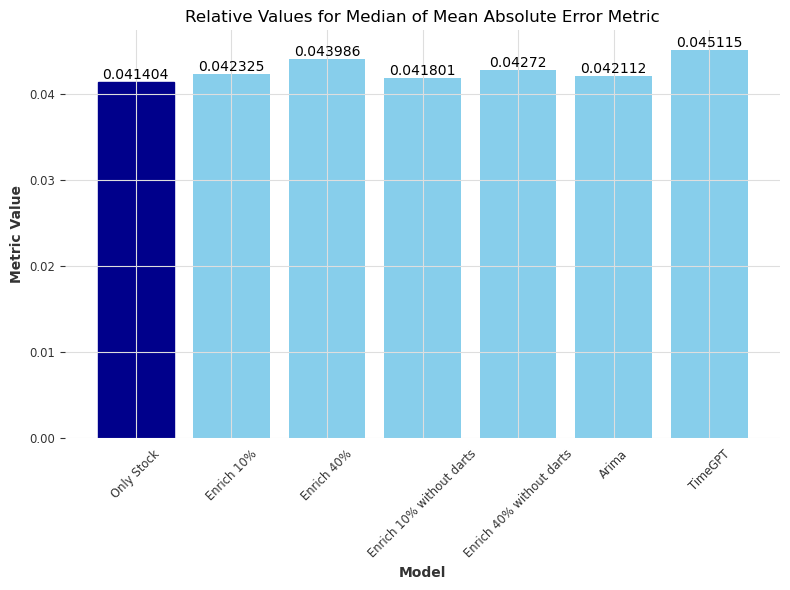

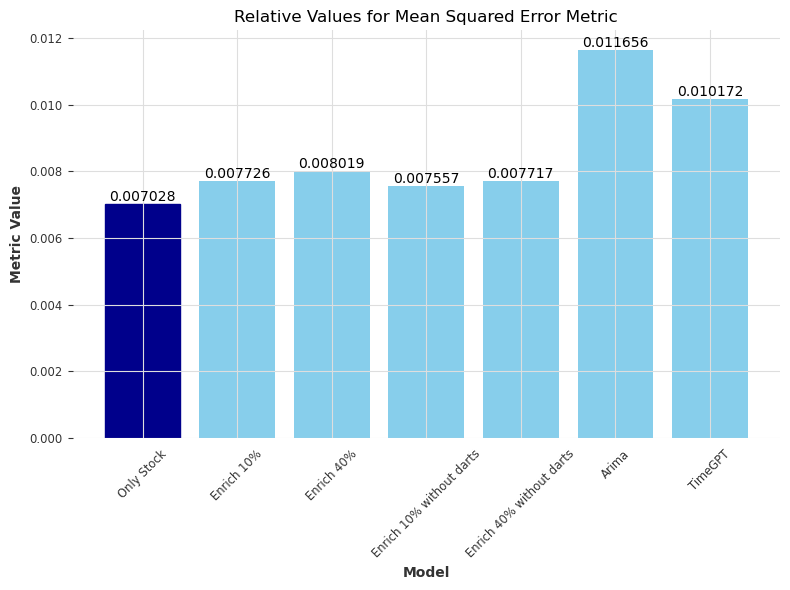

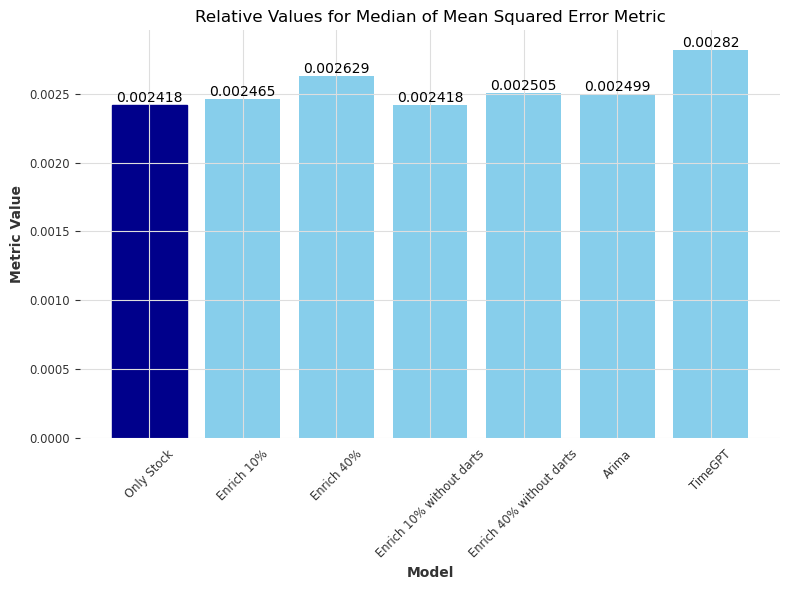

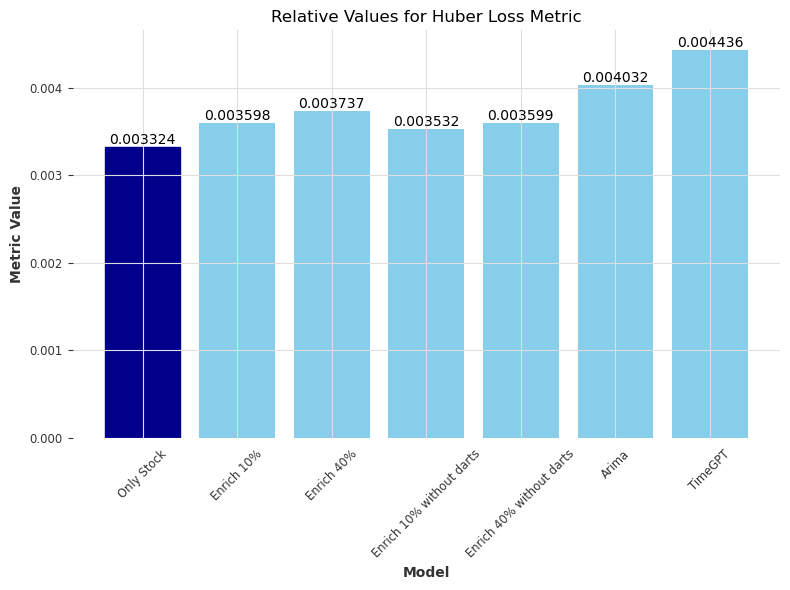

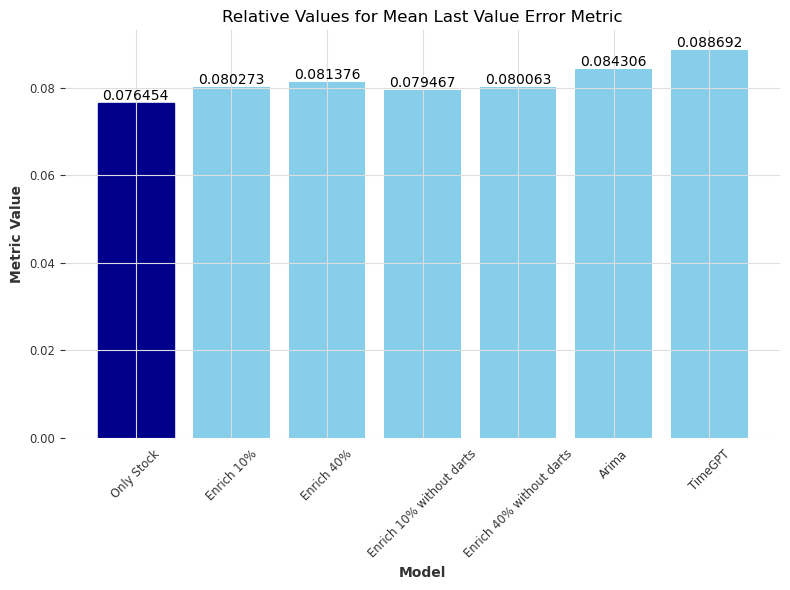

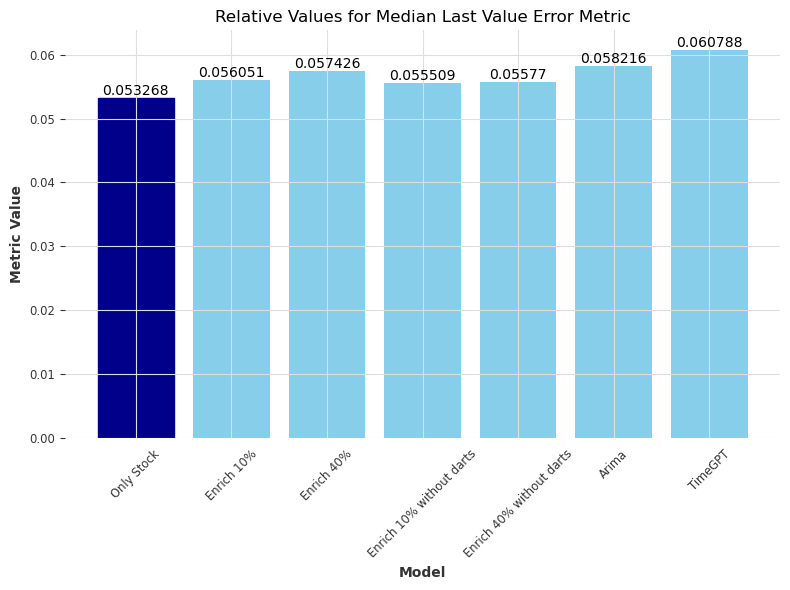

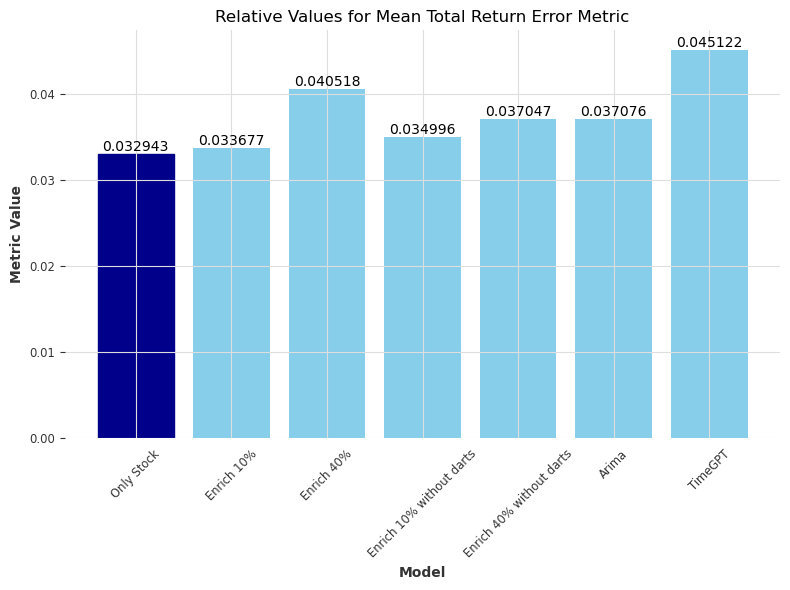

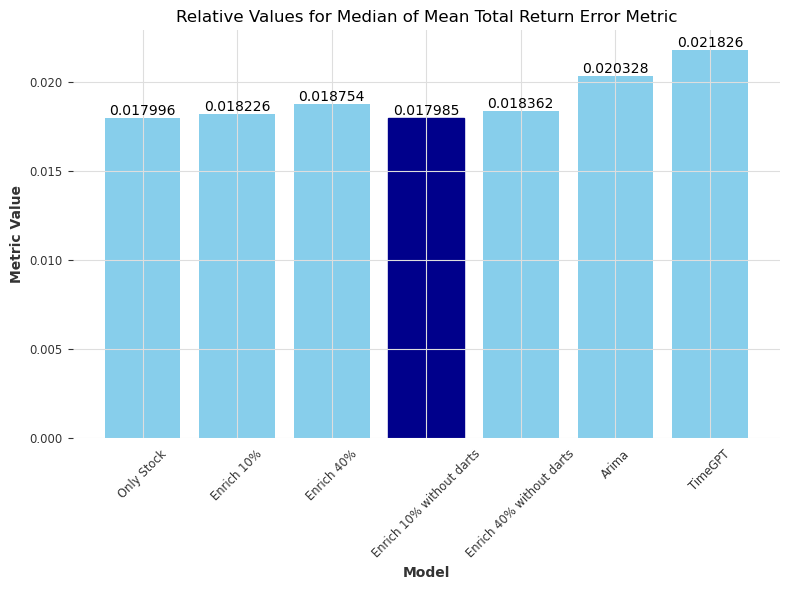

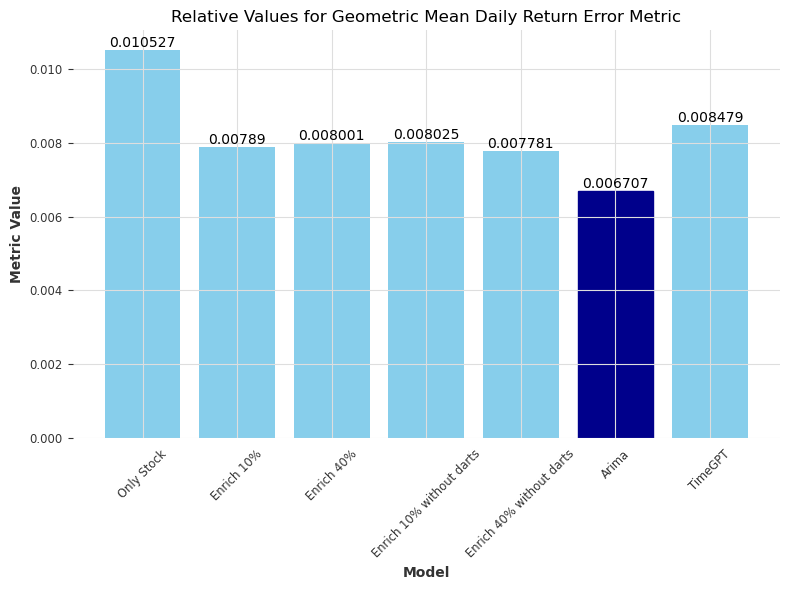

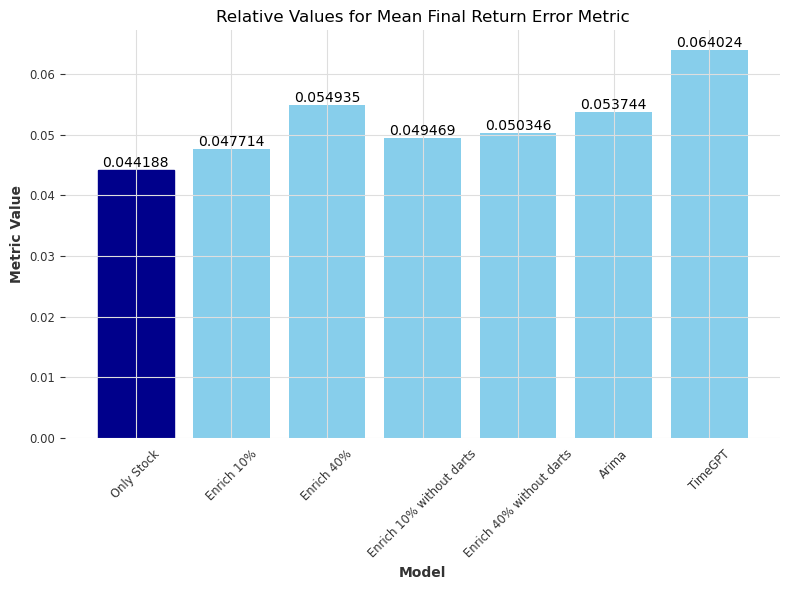

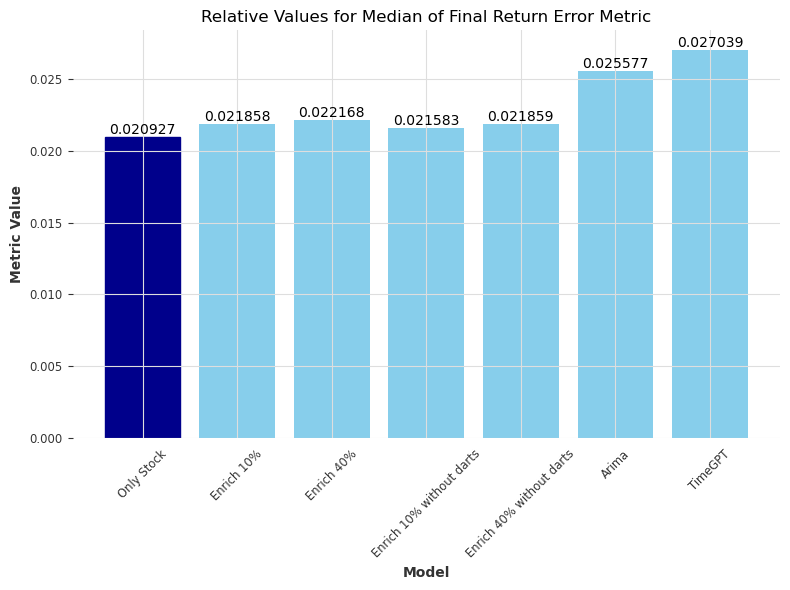

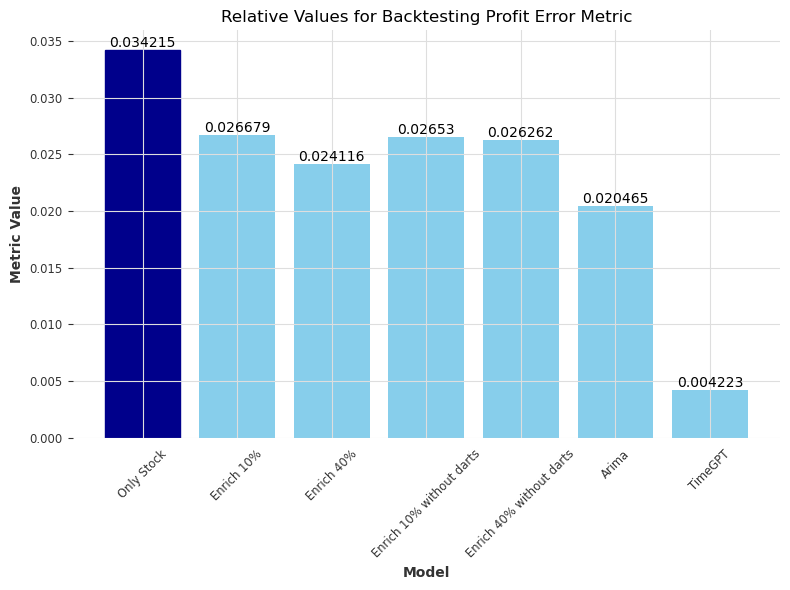

In [25]:
for i, loss_function in enumerate(df.index):
    plt.figure(figsize=(8, 6))
    bars = plt.bar(df.columns, df.loc[loss_function], color='skyblue')
    
    # Find the index of the minimum value
    
    
    # Change the color of the lowest bar to stand out
    if i == 12:
        max_index = df.loc[loss_function].idxmax()
        bars[df.columns.get_loc(min_index)].set_color('darkblue')
    else:
        min_index = df.loc[loss_function].idxmin()
        bars[df.columns.get_loc(min_index)].set_color('darkblue')
    
    plt.title(f'Relative Values for {loss_function} Metric')
    plt.xlabel('Model')
    plt.ylabel('Metric Value')
    plt.xticks(rotation=45)
    
    for bar, value in zip(bars, df.loc[loss_function]):
        plt.text(bar.get_x() + bar.get_width() / 2, 
                 bar.get_height(), 
                 round(value, 6), 
                 ha='center', 
                 va='bottom')
    
    plt.tight_layout()
    plt.savefig(f"relative_metrices_{loss_function}.png")
    plt.show()
